In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pharma-sales-data/salesdaily.csv
/kaggle/input/pharma-sales-data/salesweekly.csv
/kaggle/input/pharma-sales-data/salesmonthly.csv
/kaggle/input/pharma-sales-data/saleshourly.csv


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
# from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, roc_curve, auc, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

2024-04-07 17:17:24.716126: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 17:17:24.716307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 17:17:24.896283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
salesdaily=pd.read_csv('/kaggle/input/pharma-sales-data/salesdaily.csv')
saleshourly=pd.read_csv('/kaggle/input/pharma-sales-data/saleshourly.csv')
salesmonthly=pd.read_csv('/kaggle/input/pharma-sales-data/salesmonthly.csv')
salesweekly=pd.read_csv('/kaggle/input/pharma-sales-data/salesweekly.csv')

In [4]:
salesdaily.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


In [5]:
saleshourly.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014 8:00,0.0,0.67,0.4,2.0,0.0,0.0,0.0,1.0,2014,1,8,Thursday
1,1/2/2014 9:00,0.0,0.00,1.0,0.0,2.0,0.0,0.0,0.0,2014,1,9,Thursday
2,1/2/2014 10:00,0.0,0.00,0.0,3.0,2.0,0.0,0.0,0.0,2014,1,10,Thursday
3,1/2/2014 11:00,0.0,0.00,0.0,2.0,1.0,0.0,0.0,0.0,2014,1,11,Thursday
4,1/2/2014 12:00,0.0,2.00,0.0,5.0,2.0,0.0,0.0,0.0,2014,1,12,Thursday


In [6]:
salesweekly.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,1/5/2014,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,1/12/2014,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,1/19/2014,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
3,1/26/2014,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
4,2/2/2014,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


In [7]:
salesmonthly.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


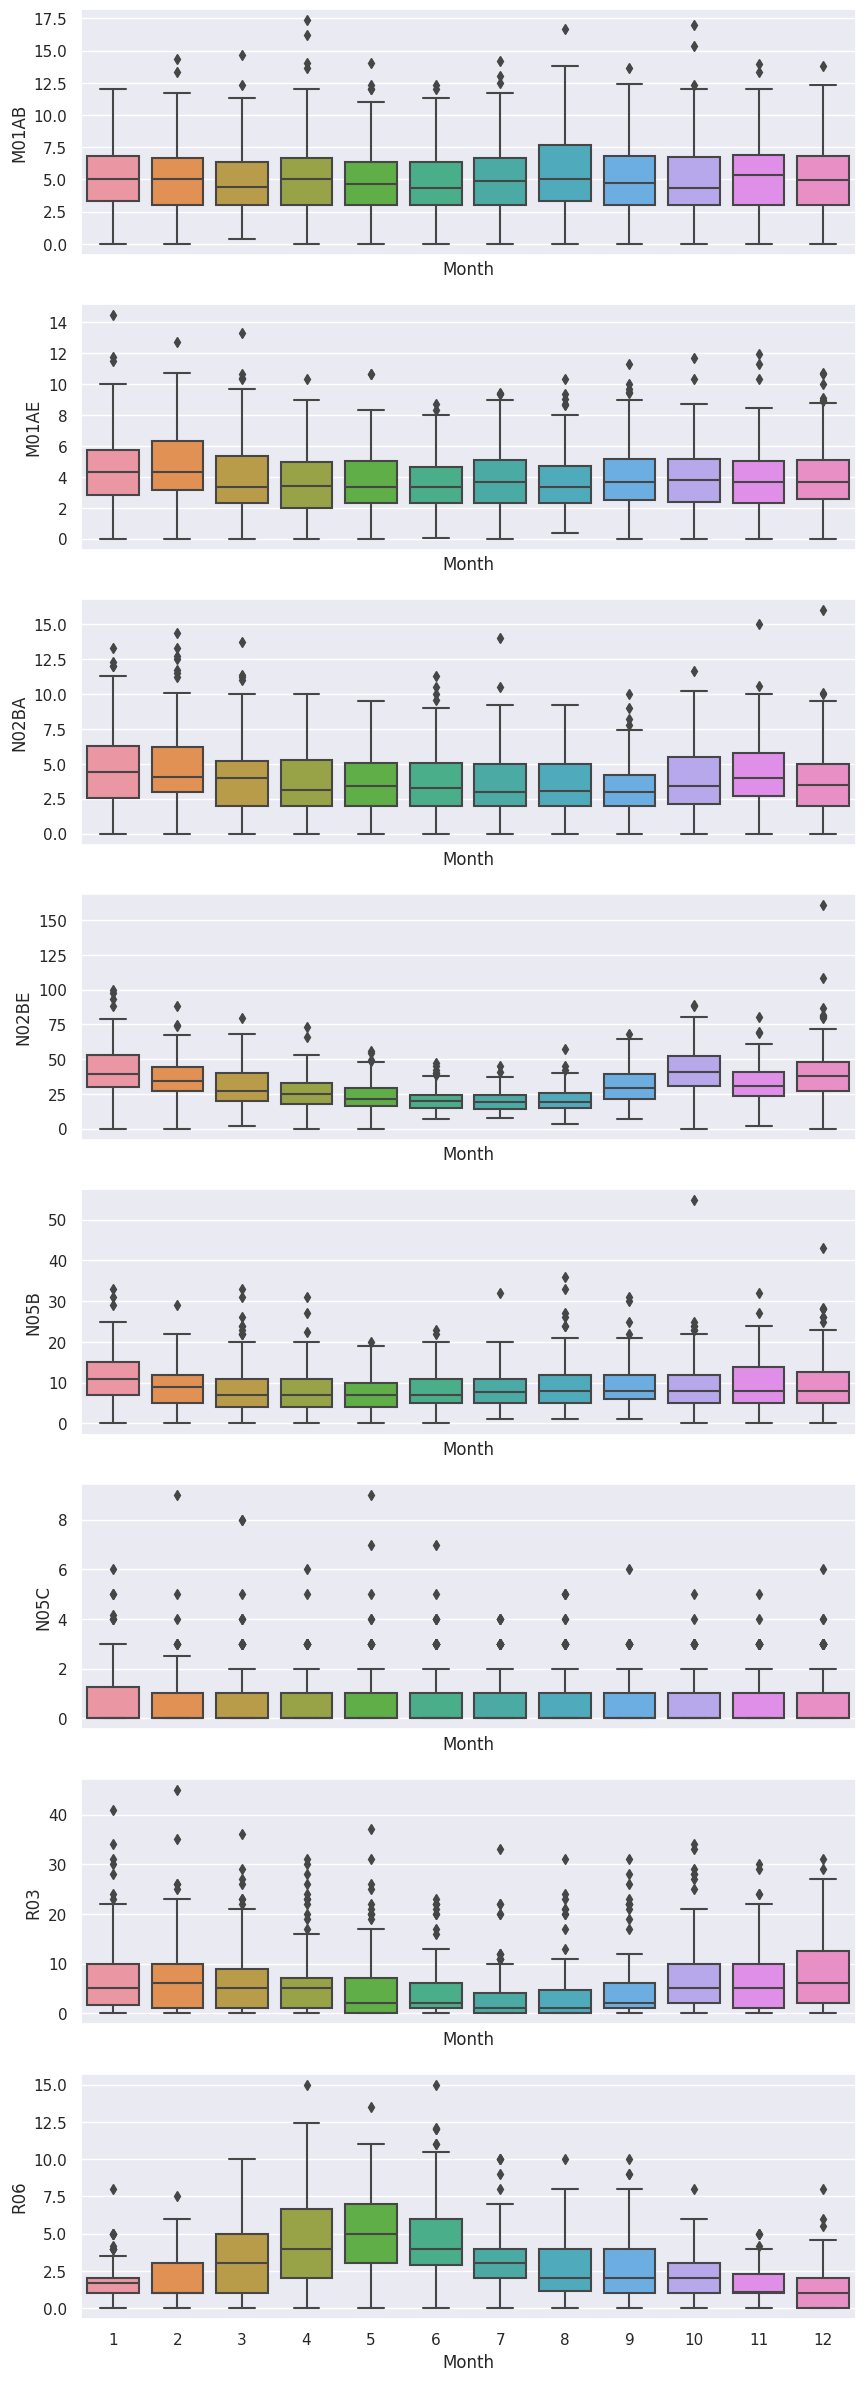

In [8]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=salesdaily, x='Month', y=name, ax=ax)

## **Import Libraries**

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import RootMeanSquaredError

## **Load Data**

In [10]:
data = pd.read_csv('/kaggle/input/pharma-sales-data/salesmonthly.csv')

## **Data Preprocessing**

In [11]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 datum    0
M01AB    0
M01AE    0
N02BA    0
N02BE    0
N05B     0
N05C     0
R03      0
R06      0
dtype: int64


In [12]:
atc_categories = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
category_sales = {}
for category in atc_categories:
    category_sales[category] = data.groupby(category).sum()

In [13]:
data.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


In [14]:
data.shape

(70, 9)

In [15]:
# Assuming 'salesdaily' is your DataFrame and 'datum' column contains dates as strings
salesmonthly['datum'] = pd.to_datetime(salesmonthly['datum'])

In [16]:
salesmonthly

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.20
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.20
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.40
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.70
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.70
...,...,...,...,...,...,...,...,...,...
65,2019-06-30,151.54,101.627,103.200,610.000,193.0,25.0,142.0,156.04
66,2019-07-31,181.00,103.541,92.800,649.800,250.6,20.0,115.0,105.20
67,2019-08-31,181.91,88.269,84.200,518.100,237.0,26.0,145.0,97.30
68,2019-09-30,161.07,111.437,93.500,984.480,227.8,16.0,161.0,109.10


In [17]:
print(salesmonthly['datum'].min())
print(salesmonthly['datum'].max())

2014-01-31 00:00:00
2019-10-31 00:00:00


In [18]:
# Reshape the dataframe
salesmonthly_new = salesmonthly.melt(id_vars=['datum'],
             var_name='Drug',
             value_name='Quantity')

# Print the updated dataframe
salesmonthly_new

,datum,Drug,Quantity
0,2014-01-31,M01AB,127.69
1,2014-02-28,M01AB,133.32
2,2014-03-31,M01AB,137.44
3,2014-04-30,M01AB,113.10
4,2014-05-31,M01AB,101.79
...,...,...,...
555,2019-06-30,R06,156.04
556,2019-07-31,R06,105.20
557,2019-08-31,R06,97.30
558,2019-09-30,R06,109.10


In [19]:
import plotly.express as px

# Plot the graph on drug basis
fig = px.line(salesmonthly_new, x='datum', y='Quantity', color='Drug', 
              title='Monthly Sales Quantity of Drugs', labels={'datum': 'Date', 'Quantity': 'Sales Quantity'})

# Show the plot
fig.show()

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [21]:
salesmonthly_new['datum'] = le.fit_transform(salesmonthly_new['datum'])
salesmonthly_new['Drug'] = le.fit_transform(salesmonthly_new['Drug'])
salesmonthly_new

,datum,Drug,Quantity
0,0,0,127.69
1,1,0,133.32
2,2,0,137.44
3,3,0,113.10
4,4,0,101.79
...,...,...,...
555,65,7,156.04
556,66,7,105.20
557,67,7,97.30
558,68,7,109.10


In [22]:
# Create a new index column
salesmonthly_new['Index'] = range(len(salesmonthly_new))

# Set 'Index' as the index
salesmonthly_new.set_index('Index', inplace=True)

In [23]:
salesmonthly_new

,datum,Drug,Quantity
Index,,,
0,0,0,127.69
1,1,0,133.32
2,2,0,137.44
3,3,0,113.10
4,4,0,101.79
...,...,...,...
555,65,7,156.04
556,66,7,105.20
557,67,7,97.30


## **Model Fitting**

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 1.4228 - val_loss: 0.6039 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.3599 - val_loss: 0.5860 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.0717 - val_loss: 0.5758 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.9729 - val_loss: 0.5839 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.0302 - val_loss: 0.5745 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.9138 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.8784 - val_loss: 0.5970 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.8301 - val_loss: 0.5930 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.7094 - val_loss: 0.5881 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━

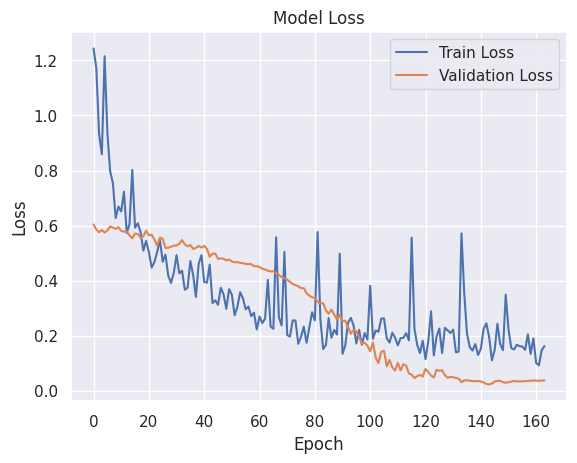

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Function to prepare data
def prepare_data(time_data, n_features):
    X, y = [], []
    for i in range(len(time_data)):
        end_ix = i + n_features
        if end_ix > len(time_data) - 1:
            break
        X.append(time_data[i:end_ix])
        y.append(time_data[end_ix])
    return np.array(X), np.array(y)

# Splitting data into train and test sets
split_index = 550
train = salesmonthly_new.iloc[:split_index]
test = salesmonthly_new.iloc[split_index:]

# Extract features and target
X_train = train.drop(['datum'], axis=1).values
y_train = train['Quantity'].values
X_test = test.drop(['datum'], axis=1).values
y_test = test['Quantity'].values

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Normalize target variable
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Define the LSTM model architecture
def create_lstm_model(input_shape, n_units=256, n_layers=3, dropout_rate=0.3):
    model = Sequential()
    for i in range(n_layers):
        model.add(LSTM(units=n_units, activation='relu', return_sequences=True if i < n_layers - 1 else False,
                       input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer
    return model

# Create the LSTM model
n_features = X_train.shape[1]
input_shape = (n_features, 1)
model = create_lstm_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mae')

# Early stopping and learning rate reduction to prevent overfitting
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
train_mae = np.mean(np.abs(model.predict(X_train) - y_train))
val_mae = np.mean(np.abs(model.predict(X_val) - y_val))

print('Train Loss:', train_loss)
print('Validation Loss:', val_loss)
print('Train MAE:', train_mae)
print('Validation MAE:', val_mae)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **Forecasting**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


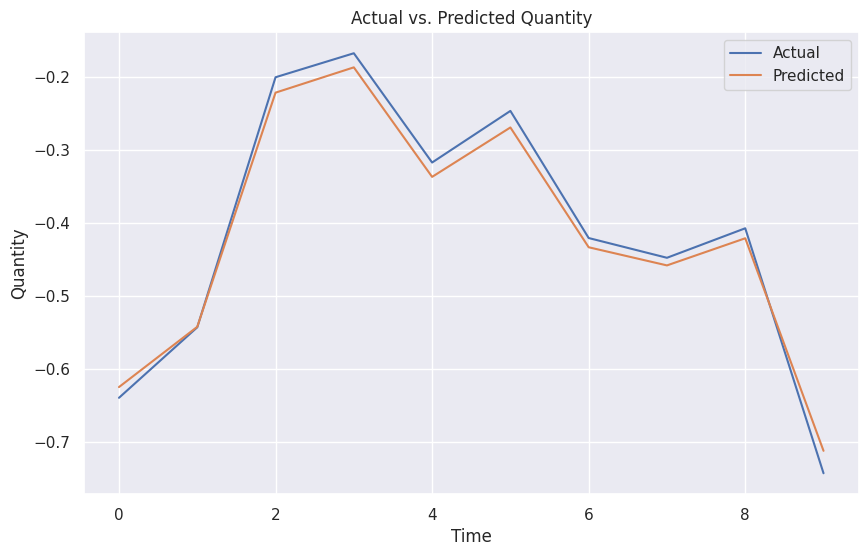

In [25]:
# Make predictions on the test data
predictions = model.predict(X_test)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs. Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()